Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
---> Epoch 0
ave mse 1.957 ===> Total training time: 0.164 seconds.
---> Epoch 1
ave mse 1.806 ===> Total training time: 0.404 seconds.
---> Epoch 2
ave mse 1.705 ===> Total training time: 0.652 seconds.
---> Epoch 3
ave mse 1.626 ===> Total training time: 0.898 seconds.
---> Epoch 4
ave mse 1.557 ===> Total training time: 1.15 seconds.
---> Epoch 5
ave mse 1.497 ===> Total training time: 1.392 seconds.
---> Epoch 6
ave mse 1.442 ===> Total training time: 1.65 seconds.
---> Epoch 7
ave mse 1.391 ===> Total training time: 1.903 seconds.
---> Epoch 8
ave mse 1.344 ===> Total training time: 2.172 seconds.
---> Epoch 9
ave mse 1.3 ===> Total training time: 2.431 seconds.
---> Epoch 10
ave mse 1.258 ===> Total training time: 2.692 seconds.
---> Epoch 11
ave mse 1.219 ===> Total training time: 2.935 seconds.
---> Epoch 12
ave mse 1.182 ===> Total training time: 3.1

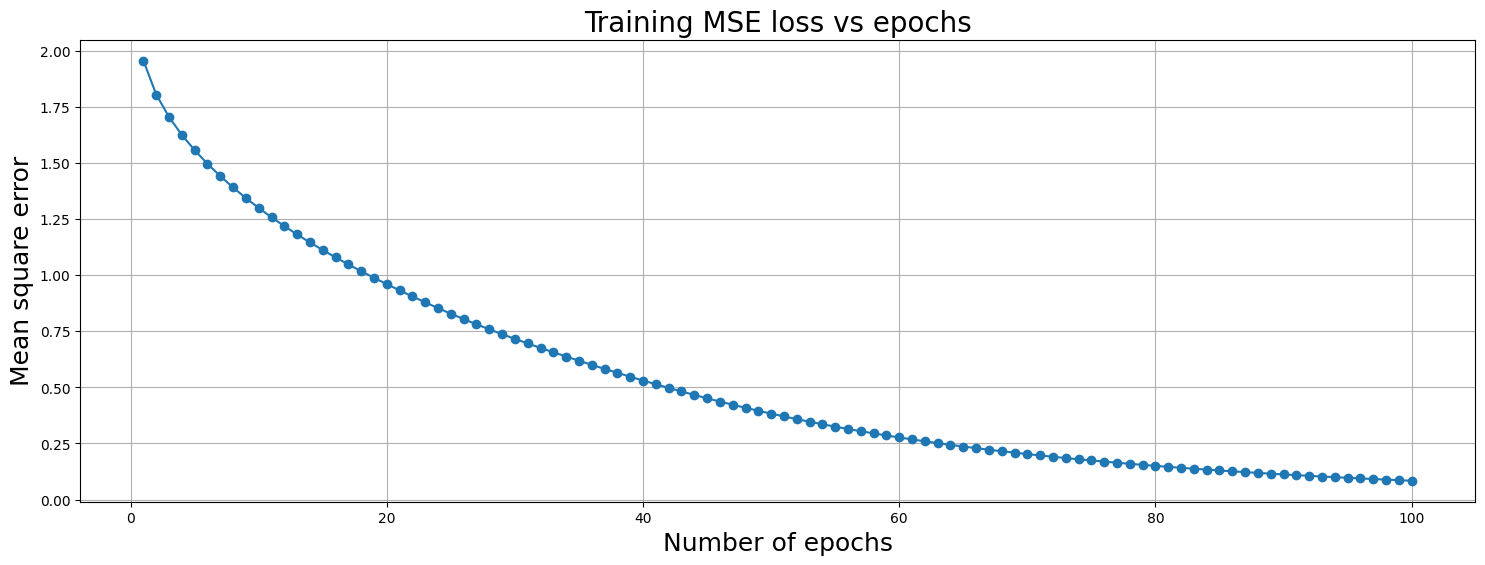

In [8]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load training data from Google Drive
df = pd.read_csv('/content/drive/MyDrive/train.csv')

# Load test data from Google Drive
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

# Column names of the dataset
user_col, name_col, rating_col = 'user_id', 'name', 'stars'

# Filter training data: Keep only users and items with minimum interactions
filtered_df = df.groupby(user_col).filter(lambda x: len(x) >= 5)
filtered_df = filtered_df.groupby(name_col).filter(lambda x: len(x) >= 5)

# Reduce dataset size: Limit to 10,000 rows to save memory
filtered_df = filtered_df.sample(n=10000, random_state=42)
filtered_df = filtered_df[filtered_df[name_col] != 'Apple Store']

# Convert user_id and name to numeric values
user_ids, user_names = pd.factorize(filtered_df[user_col])
name_ids, name_labels = pd.factorize(filtered_df[name_col])
ratings_data = filtered_df[rating_col].values.astype(np.int32)

# Create a CSR matrix for training data
ratings = csr_matrix(
    (ratings_data, (user_ids, name_ids)),
    shape=(len(np.unique(user_ids)), len(np.unique(name_ids)))
).toarray()

# Convert to DataFrame
user_item_matrix = pd.DataFrame(ratings, index=user_names, columns=name_labels)

class MatrixFactorization():
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate
        self.alpha = alpha
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    def initialize(self):
        self.now = time.time()
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)

    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + self.user_vecs[u] @ self.item_vecs[i]

    def update_biases_and_vectors(self, error, u, i):
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i] - pred_rat) ** 2
        mse = tot_square_error / self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")

    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time() - self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i] - pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.conv_epoch_num = epoch
        self.plot_the_score()

    def result(self):
        return self.user_vecs, self.item_vecs

    def filled_user_item_matrix(self):
        filled_matrix = np.zeros((self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                filled_matrix[u, i] = self.predict(u, i)
        return pd.DataFrame(filled_matrix, index=user_names, columns=name_labels)

    def plot_the_score(self):
        plt.figure(figsize=(18, 6))
        plt.plot(range(1, 1 + len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("Training MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('Mean square error', fontsize=18)
        plt.grid()
        plt.show()

# 모델 초기화 및 학습
obj = MatrixFactorization(ratings)
obj.fit()

# 채워진 사용자-아이템 매트릭스 반환
filled_user_item_matrix = obj.filled_user_item_matrix()


In [9]:
filled_user_item_matrix

,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,Insomnia Cookies,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Rpqf0uVt6XENIvrbaSciiA,4.133581,3.497587,4.212516,4.221969,2.480813,3.398964,2.643601,3.301508,4.103281,4.289256,...,2.888567,4.171809,2.323214,4.172663,3.316081,4.172550,2.474804,3.745356,3.894564,4.174265
TFw7YRiyl4r2nw3_JFh2Ww,3.211773,2.504674,3.291886,3.304190,1.500834,2.496646,1.732827,2.383811,3.187935,3.373590,...,1.976786,3.259324,1.399201,3.252494,2.396769,3.259313,1.546879,2.828691,2.976690,3.258291
_BcWyKQL16ndpBdggh2kNA,4.176756,3.567108,4.593281,4.249712,2.459789,3.409623,2.673256,3.317280,4.133717,4.350135,...,2.893871,4.210294,2.347190,4.184558,3.361540,4.189201,2.506322,3.778642,3.916694,4.207728
NAtkmn07-dNVA6YMqZCs6Q,4.672362,4.024567,4.749644,4.781228,3.017308,3.945876,3.155697,3.832825,4.640586,4.821352,...,3.428738,4.706068,2.848676,4.707804,3.848670,4.703812,3.002707,4.281386,4.430313,4.706555
UaHRbDqkiCPZPZpymIziHQ,3.508853,2.851988,3.598625,3.593301,1.036486,2.813786,1.957286,2.675766,3.482307,3.672459,...,2.254739,3.550224,1.689853,3.552257,2.685674,3.544450,1.837044,3.112661,3.267930,3.541892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7iFUtwc9hhgGCThohNFwtw,3.235226,2.604657,3.299284,3.320668,1.560011,2.560477,1.608812,2.393968,3.202434,3.395425,...,1.981024,3.265997,1.408231,3.266865,2.416570,3.268850,1.575829,2.842526,2.996196,3.273230
UIeRnK42UJm0_drjF3IpcA,2.722638,2.079736,2.805720,2.816299,1.075780,2.038789,1.054406,1.874452,2.691187,2.855677,...,1.489071,2.753825,0.895120,2.756521,1.891899,2.745205,1.051530,2.323444,2.479972,2.763899
UCUiESd5WPj4c3CkyOIi5Q,4.811832,4.176763,4.899395,4.902419,3.151739,4.082047,3.336245,3.977984,4.782175,4.966530,...,3.570309,4.850943,3.002493,4.850358,3.994206,4.849178,3.144882,4.421771,4.572809,4.848534
cTjFQS2Yyuc27rH0zQ2gyg,5.441558,4.806821,5.527958,5.520939,3.895196,4.724149,3.816952,4.613378,5.407269,5.588695,...,4.194881,5.481003,3.634651,5.477361,4.622653,5.487462,3.784481,5.055465,5.204150,5.485269


In [10]:
user_item_matrix

,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,Insomnia Cookies,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Rpqf0uVt6XENIvrbaSciiA,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TFw7YRiyl4r2nw3_JFh2Ww,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_BcWyKQL16ndpBdggh2kNA,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAtkmn07-dNVA6YMqZCs6Q,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UaHRbDqkiCPZPZpymIziHQ,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7iFUtwc9hhgGCThohNFwtw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UIeRnK42UJm0_drjF3IpcA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UCUiESd5WPj4c3CkyOIi5Q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cTjFQS2Yyuc27rH0zQ2gyg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# 학습된 사용자와 아이템 벡터 가져오기
user_vecs, item_vecs = obj.result()

# 테스트 데이터 준비
test_user_ids, _ = pd.factorize(test_df[user_col])
test_item_ids, _ = pd.factorize(test_df[name_col])
test_ratings = pd.to_numeric(test_df[rating_col], errors='coerce').fillna(0).values

# 테스트 세트에 대한 예측 계산
predictions = [
    np.clip(obj.predict(test_user_ids[i], test_item_ids[i]), 1, 5)
    if (test_user_ids[i] < len(user_vecs) and test_item_ids[i] < len(item_vecs))
    else np.nan
    for i in range(len(test_user_ids))
]

# 테스트 세트에 대한 예측 평가
test_df['predicted_rating'] = predictions
mse = ((pd.to_numeric(test_df[rating_col], errors='coerce') - test_df['predicted_rating']) ** 2).mean()
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# 랜덤 사용자 선택 후 상위 3개 추천 항목 출력
random_user = np.random.choice(test_user_ids)
item_scores = [(i, np.clip(obj.predict(random_user, i), 1, 5)) for i in range(len(item_vecs))]
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

print("\nTop 3 recommendations for user {}:".format(random_user))
for idx, score in item_scores[:3]:
    print(f"Restaurant: {name_labels[idx]}, Predicted Rating: {score}")

Test RMSE: 1.7034073757942114

Top 3 recommendations for user 2491:
Restaurant: Fatdogs, Predicted Rating: 5.0
Restaurant: Strange Donuts, Predicted Rating: 5.0
Restaurant: Ruby Buffet, Predicted Rating: 4.995403905212533
